In [1]:
import inca
from inca_calibration import *
import numpy as np

### Set up

In [41]:
inca.initialize('simplyp.dll')
dataset = inca.DataSet.setup_from_parameter_and_input_files('../Applications/SimplyP/tarlandparameters.dat',
                                                            '../Applications/SimplyP/tarlandinputs.dat')

### Take a look at what is contained in the dataset

In [53]:
print ('Index sets: %s' %dataset.get_index_sets())
print ('Indices in 1st index set: %s' %dataset.get_indexes(dataset.get_index_sets()[0]))
print ('Indices in 2nd index set: %s' %dataset.get_indexes(dataset.get_index_sets()[1]))

Index sets: [u'Reaches', u'Landscape units']
Indices in 1st index set: [u'Tarland1']
Indices in 2nd index set: [u'Arable', u'Improved grassland', u'Semi-natural']


In [55]:
air_temp = dataset.get_input_series('Air temperature',[])
air_temp

array([2.91, 4.37, 2.53, ..., 2.01, 1.73, 3.48])

In [56]:
dataset.get_parameter_list()

[(u'Timesteps', u'uint'),
 (u'Start date', u'time'),
 (u'Latitude', u'double'),
 (u'Initial snow depth', u'double'),
 (u'Degree-day factor for snowmelt', u'double'),
 (u'Proportion of precipitation that contributes to quick flow', u'double'),
 (u'PET reduction factor', u'double'),
 (u'Soil field capacity', u'double'),
 (u'Baseflow index', u'double'),
 (u'Groundwater time constant', u'double'),
 (u'Minimum groundwater flow', u'double'),
 (u'Gradient of stream velocity-discharge relationship', u'double'),
 (u'Exponent of stream velocity-discharge relationship', u'double'),
 (u'Catchment area', u'double'),
 (u'Reach length', u'double'),
 (u'Initial in-stream flow', u'double'),
 (u'Soil water time constant', u'double'),
 (u'Land use proportions', u'double'),
 (u'Reach sediment input scaling factor', u'double'),
 (u'Sediment input non-linear coefficient', u'double'),
 (u'Day of year when soil erodibility is at its max for spring-grown crops',
  u'uint'),
 (u'Day of year when soil erodibilit

### Run the model to see what the results look like with manually-calibrated parameters

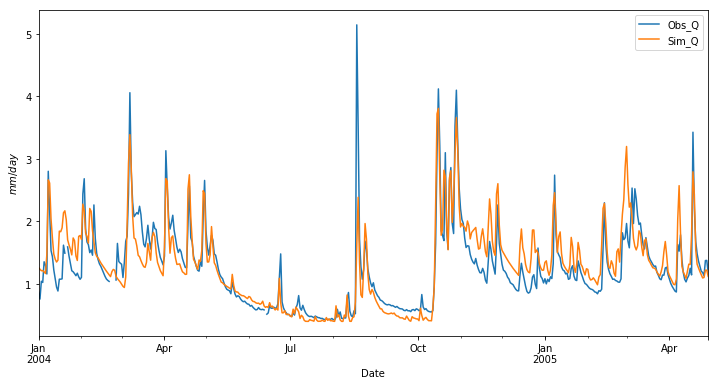

In [42]:
dataset.run_model()

# Read data from the dataset
simQ = dataset.get_result_series('Reach flow (daily mean, mm/day)', ['Tarland1'])
obsQ = dataset.get_input_series('observed Q mm/d', [], alignwithresults=True)
start_date = dt.datetime.strptime(dataset.get_parameter_time('Start date', []),'%Y-%m-%d')
timesteps = dataset.get_parameter_uint('Timesteps', [])
unit = dataset.get_result_unit('Reach flow (daily mean, mm/day)')

# Use data to make a pandas dataframe
date_idx = np.array(pd.date_range(start_date, periods=timesteps))
df = pd.DataFrame({'Date':date_idx, 'Obs_Q': obsQ, 'Sim_Q': simQ})
df.set_index('Date', inplace=True)

# Plot
fig, ax = plt.subplots()
df.plot(figsize=(12,6), ax=ax)
ax.set_ylabel('$%s$' % unit)
plt.show()

### Set up for optimization

Pick out the parameters we want to calibrate, and set initial values for them as well as minimum and maximum limits we want the algorithm to search within.

In [30]:
#NOTE: The 'calibration' structure is a list of (indexed) parameters that we want to calibrate
calibration = [
    ('Degree-day factor for snowmelt',                             []),
    ('Proportion of precipitation that contributes to quick flow', []),
    ('PET reduction factor',                                       []),
    ('Baseflow index',                                             []),
    ('Groundwater time constant',                                  []),
    ('Gradient of stream velocity-discharge relationship',         []),
    ('Exponent of stream velocity-discharge relationship',         []),
    ('Soil water time constant',                                   ['Arable']),
    ('Soil water time constant',                                   ['Semi-natural']),
    ('Soil field capacity',                                        []),
    ('Minimum groundwater flow',                                   []),
    ]

# Read the initial guess provided by the parameter file
initial_guess = default_initial_guess(dataset, calibration)
initial_guess.append(0.5) # Variance of residual error term, also to be optimized

# Set upper and lower limits for parameter values
param_min = [0.1 * x for x in initial_guess]
param_max = [10.0 * x for x in initial_guess]

constrain_min_max(dataset, calibration, param_min, param_max) # NOTE: Constrain to the min and max values recommended
                                                              # by the model in case we made our bounds too wide.

skiptimesteps = 50   # Skip these many of the first timesteps in the objective evaluation

objective = (log_likelyhood, 'Reach flow (daily mean, mm/day)', ['Tarland1'], 'observed Q mm/d', [], skiptimesteps)

### Run the optimizer and print the results

In [31]:
param_est = run_optimization(dataset, param_min, param_max, initial_guess, calibration, objective, minimize=False)
#param_est = param_est[0]

Optimization terminated successfully.
         Current function value: -70.968773
         Iterations: 3030
         Function evaluations: 4274


In [32]:
for idx, cal in enumerate(calibration) :
    name, indexes = cal
    print('Estimated %-60s %-20s %5.2f (range [%5.2f, %5.2f])' %  (name, ', '.join(indexes), param_est[idx], min[idx], max[idx]))
if len(param_est) > len(calibration) :
    print('M: %f' % param_est[len(calibration)])

Estimated Degree-day factor for snowmelt                                                     1.37 (range [ 0.27,  5.00])
Estimated Proportion of precipitation that contributes to quick flow                         0.03 (range [ 0.00,  0.20])
Estimated PET reduction factor                                                               1.00 (range [ 0.10,  1.00])
Estimated Baseflow index                                                                     0.60 (range [ 0.07,  1.00])
Estimated Groundwater time constant                                                         108.72 (range [ 6.50, 400.00])
Estimated Gradient of stream velocity-discharge relationship                                 0.48 (range [ 0.05,  0.99])
Estimated Exponent of stream velocity-discharge relationship                                 0.19 (range [ 0.10,  0.99])
Estimated Soil water time constant                                     Arable                1.31 (range [ 0.10, 10.00])
Estimated Soil water time cons

### Save the optimized parameter values

Write the optimal values back to the dataset, and then generate a new parameter file that has these values

In [33]:
set_values(dataset, param_est, calibration)
dataset.write_parameters_to_file('optimal_parameters.dat')

### Run with optimal parameters and plot

Run the model one more time with the optimal parameters and plot simulated output. Save figure to file, and optionally display it here too.

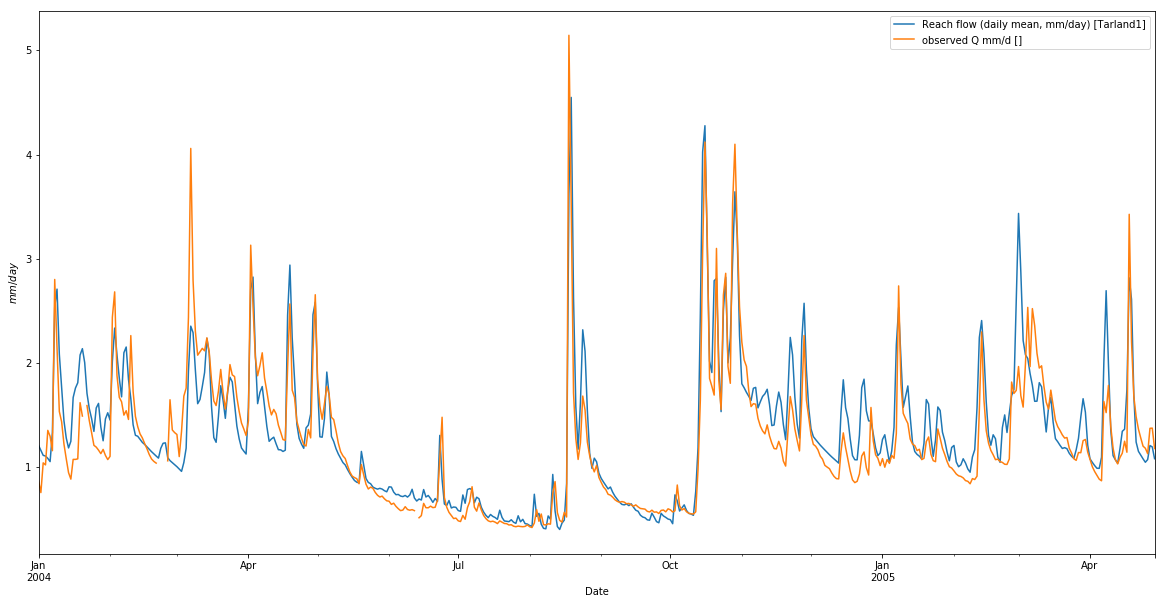

In [34]:
dataset.run_model()
fig, ax = plot_objective(dataset, objective, "simplyp_plots\\optimizer_MAP.png", return_fig=True)
plt.show()